In [ ]:
!pip install pyspark
!pip install geopandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 1.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.2-py2.py3-none-any.whl size=317812365 sha256=0c51b24431390dbc7b3c8b942724cbe9da4958b5fe59ddcd47fba6d57b45fc83
  Stored in directory: /root/.cache/pip/wheels/34/34/bd/03944534c44b677cd5859f248090daa9fb27b3c8f8e5f49574
Successfully built pyspark


In [ ]:
from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.functions import round
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType

import matplotlib.pyplot as plt
import geopandas as gpd
import ast
import time
import requests

In [ ]:
API_KEY = ''

In [ ]:
with open('cities.txt', 'r') as fp:
  temp = fp.read()
temp

'[{\'name\': \'Acrelândia\', \'lat\': -10.0759167, \'lon\': -67.0526898, \'country\': \'BR\', \'state\': \'Acre\'}, {\'name\': \'Assis Brasil\', \'lat\': -10.9409203, \'lon\': -69.5672108, \'country\': \'BR\', \'state\': \'Acre\'}, {\'name\': \'Brasiléia\', \'lat\': -11.0010413, \'lon\': -68.7487894, \'country\': \'BR\', \'state\': \'Acre\'}, {\'name\': \'Bujari\', \'lat\': -9.8309656, \'lon\': -67.9520886, \'country\': \'BR\', \'state\': \'Acre\'}, {\'name\': \'Capixaba\', \'lat\': -10.5741345, \'lon\': -67.6759719, \'country\': \'BR\', \'state\': \'Acre\'}, {\'name\': \'Cruzeiro do Sul\', \'local_names\': {\'ru\': \'Крузейру-ду-Сул\', \'bg\': \'Крузейро до Сул\', \'mk\': \'Крусејро до Сул\', \'pt\': \'Cruzeiro do Sul\'}, \'lat\': -7.6307956, \'lon\': -72.6703869, \'country\': \'BR\', \'state\': \'Acre\'}, {\'name\': \'Epitaciolândia\', \'lat\': -11.0289439, \'lon\': -68.7411519, \'country\': \'BR\', \'state\': \'Acre\'}, {\'name\': \'Feijó\', \'local_names\': {\'ru\': \'Фейжо\', \'pt

In [ ]:
temp = ast.literal_eval(temp)

In [ ]:
spark = SparkSession.builder.appName('airPollutionStates').getOrCreate()

In [ ]:
all_cities = spark.createDataFrame(temp)

In [ ]:
def filter_cities(df: DataFrame, state: str) -> DataFrame:
  return df.filter(df['state'] == state).drop('local_names')

In [ ]:
def round_to_2(df: DataFrame) -> DataFrame:
  return df.withColumn("lat_rounded", round(df.lat, 2)).withColumn("lon_rounded", round(df.lon, 2))

In [ ]:
df_mt = filter_cities(all_cities, 'Mato Grosso')
df_sp = filter_cities(all_cities, 'São Paulo')

In [ ]:
df_mt.show(10)
df_sp.show(10)

+-------+-----------+------------------+--------------+-----------+
|country|        lat|               lon|          name|      state|
+-------+-----------+------------------+--------------+-----------+
|     BR|-15.2001544|       -56.3668953|      Acorizal|Mato Grosso|
|     BR|-14.0522968|       -52.1617625|      Água Boa|Mato Grosso|
|     BR| -9.8698547|       -56.0834993| Alta Floresta|Mato Grosso|
|     BR|-17.3156528|       -53.2169365| Alto Araguaia|Mato Grosso|
|     BR|-11.6723985|       -51.3744431|Alto Boa Vista|Mato Grosso|
|     BR|-16.9469683|        -53.529427|   Alto Garças|Mato Grosso|
|     BR|    -14.765|-56.62342364505372| Alto Paraguai|Mato Grosso|
|     BR|-17.8269099|       -53.2831736|  Alto Taquari|Mato Grosso|
|     BR| -9.5678422|        -57.394852|       Apiacás|Mato Grosso|
|     BR| -15.729144|        -51.834112|    Araguaiana|Mato Grosso|
+-------+-----------+------------------+--------------+-----------+
only showing top 10 rows

+-------+-----------+-

In [ ]:
# checking for the number of cities
print("Number of cities MT:" + str(df_mt.count()))
print("Number of cities SP:" + str(df_sp.count()))

Number of cities MT:141
Number of cities SP:645


In [ ]:
df_mt = round_to_2(df_mt)
df_sp = round_to_2(df_sp)

In [ ]:
consult_dict_mt = list(map(lambda row: row.asDict(), df_mt.collect()))
consult_dict_sp = list(map(lambda row: row.asDict(), df_sp.collect()))

In [ ]:
def consult_air_quality(consult_dict: dict) -> list:
  air_quality = []

  for item in consult_dict:
      city_air = requests.get(f"http://api.openweathermap.org/data/2.5/air_pollution?lat={item['lat_rounded']}&lon={item['lon_rounded']}&appid={API_KEY}").json()
      air_quality.append({'name': item['name'], 'aqi': city_air['list'][0]['main']['aqi'], 'co': float(city_air['list'][0]['components']['co']), 'no': float(city_air['list'][0]['components']['no']), \
          'no2': float(city_air['list'][0]['components']['no2']), 'o3': float(city_air['list'][0]['components']['o3']), 'so2': float(city_air['list'][0]['components']['so2']), 'pm2_5': float(city_air['list'][0]['components']['pm2_5']), \
          'pm10': float(city_air['list'][0]['components']['pm10']), 'nh3': float(city_air['list'][0]['components']['nh3'])})
      time.sleep(0.5)

  return air_quality

In [ ]:
air_quality_mt = consult_air_quality(consult_dict_mt)
air_quality_sp = consult_air_quality(consult_dict_sp)

In [ ]:
df_schema = StructType([StructField("name", StringType(), True)\
                       ,StructField("aqi", IntegerType(), True)
                       ,StructField("co", DoubleType(), True)
                       ,StructField("no", DoubleType(), True)
                       ,StructField("no2", DoubleType(), True)
                       ,StructField("o3", DoubleType(), True)
                       ,StructField("so2", DoubleType(), True)
                       ,StructField("pm2_5", DoubleType(), True)
                       ,StructField("pm10", DoubleType(), True)
                       ,StructField("nh3", DoubleType(), True)])

air_quality_mt_df = spark.createDataFrame(air_quality_mt, schema=df_schema)
air_quality_sp_df = spark.createDataFrame(air_quality_sp, schema=df_schema)


In [ ]:
air_quality_mt_df.show(10)
air_quality_sp_df.show(10)

+--------------+---+------+---+----+------+----+-----+-----+----+
|          name|aqi|    co| no| no2|    o3| so2|pm2_5| pm10| nh3|
+--------------+---+------+---+----+------+----+-----+-----+----+
|      Acorizal|  3|640.87|0.0|2.29|100.14|0.54|40.78|42.16|3.67|
|      Água Boa|  1|323.77|0.0|1.04| 50.07|0.18| 8.75| 9.23|1.87|
| Alta Floresta|  2|453.95|0.0|1.74| 50.07|0.28|21.69|23.38|3.67|
| Alto Araguaia|  1|307.08|0.0|1.78| 46.49|0.19| 9.84|10.39| 1.9|
|Alto Boa Vista|  2|330.45|0.0|0.75| 62.23|0.19|14.01|14.45|1.81|
|   Alto Garças|  2|327.11|0.0|1.25| 52.21|0.26|11.11|11.73| 1.9|
| Alto Paraguai|  3|594.14|0.0|1.71| 94.41|0.51| 35.4|36.77|3.42|
|  Alto Taquari|  2|333.79|0.0|1.17| 57.94|0.26|11.46|12.06|1.96|
|       Apiacás|  2|453.95|0.0|0.62| 66.52|0.19|21.18|22.84|1.49|
|    Araguaiana|  1|270.37|0.0|0.31| 32.54| 0.1| 5.17| 5.68|2.95|
+--------------+---+------+---+----+------+----+-----+-----+----+
only showing top 10 rows

+--------------------+---+------+---+-----+------+

In [ ]:
air_quality_mt_df.orderBy(air_quality_mt_df['aqi'].desc()).show()
air_quality_sp_df.orderBy(air_quality_sp_df['aqi'].desc()).show()

+--------------------+---+-------+---+----+------+----+-----+-----+----+
|                name|aqi|     co| no| no2|    o3| so2|pm2_5| pm10| nh3|
+--------------------+---+-------+---+----+------+----+-----+-----+----+
|Vila Bela da Sant...|  5|1108.17|0.0|3.17| 92.98|0.29|85.95|86.62|5.19|
| Terra Nova do Norte|  5| 921.25|0.0|7.97| 168.8|0.81| 82.9|84.95|6.27|
|     Barra do Bugres|  4| 754.36|0.0| 6.0| 43.99|0.84|52.32|54.35|4.12|
|    Pontes e Lacerda|  4| 894.55|0.0|3.51| 85.12|0.41|55.11|55.81|4.43|
|Figueirópolis d'O...|  4| 814.44|0.0|1.63| 68.67|0.38|51.53| 52.3| 4.5|
|   Nova Santa Helena|  4| 680.92|0.0|4.93|121.59|0.85|54.58|56.48| 5.0|
|             Colíder|  4| 734.33|0.0|4.37|171.66|0.81|58.03|60.06|5.32|
|              Poconé|  4| 767.71|0.0|1.09| 77.25|0.46|52.66|53.68|3.58|
|         Curvelândia|  4| 867.84|0.0|3.94| 52.21|0.47|53.07|53.88|4.69|
|    Porto Esperidião|  4| 894.55|0.0|2.83|  75.1| 0.4|53.27|53.92|5.32|
|           Itanhangá|  4| 794.41|0.0|2.38| 58.65|1

In [ ]:
def prepare_dataframes(df1: DataFrame, df2: DataFrame) -> DataFrame:
  return df1.join(df2, df1.name == df2.name, 'inner').select('lat_rounded', 'lon_rounded', 'aqi')

In [ ]:
aqi_coords_mt = prepare_dataframes(air_quality_mt_df, df_mt)
aqi_coords_mt.show(10)
plot_mt_df = aqi_coords_mt.toPandas()

aqi_coords_sp = prepare_dataframes(air_quality_sp_df, df_sp)
aqi_coords_sp.show(10)
plot_sp_df = aqi_coords_sp.toPandas()

+-----------+-----------+---+
|lat_rounded|lon_rounded|aqi|
+-----------+-----------+---+
|     -15.07|     -57.19|  4|
|      -14.5|      -57.0|  3|
|     -14.54|     -59.54|  3|
|     -14.48|     -59.59|  3|
|     -12.94|     -51.82|  1|
|     -15.73|     -51.83|  1|
|     -13.66|     -59.79|  3|
|     -15.95|     -54.98|  3|
|     -12.17|     -51.51|  1|
|     -16.49|     -52.69|  1|
+-----------+-----------+---+
only showing top 10 rows

+-----------+-----------+---+
|lat_rounded|lon_rounded|aqi|
+-----------+-----------+---+
|     -21.99|     -48.39|  3|
|     -20.19|     -47.71|  2|
|     -21.74|     -49.36|  2|
|     -20.95|     -50.11|  2|
|     -23.55|      -47.9|  1|
|     -22.23|     -50.89|  2|
|     -20.89|     -47.59|  2|
|     -21.53|     -46.64|  2|
|     -23.28|     -46.74|  5|
|      -21.3|     -50.73|  2|
+-----------+-----------+---+
only showing top 10 rows



In [ ]:
def plot_state(filename: str):
  fig, ax = plt.subplots(figsize=(5, 5))
  state = gpd.read_file(filename)

  state.plot(ax=ax, color="darkgrey")
  plt.show()
  return state

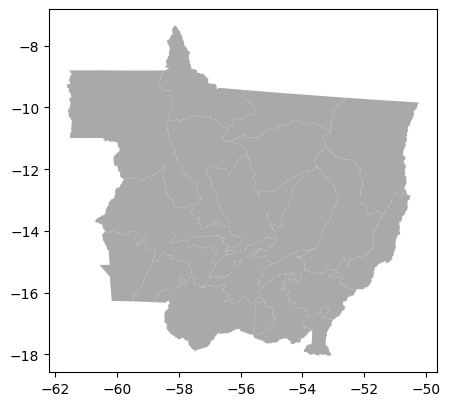

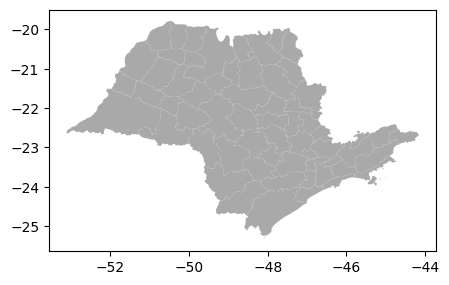

In [ ]:
mt = plot_state("MT_Microrregioes_2022.shp")
sp = plot_state("SP_Microrregioes_2022.shp")

In [ ]:
def plot_state_data(df: DataFrame, state: gpd.geodataframe.GeoDataFrame, state_name: str):
  fig, ax = plt.subplots(figsize=(7, 7))

  state.plot(ax=ax, color="darkgrey")

  scatter = ax.scatter(
      df['lon_rounded'],
      df['lat_rounded'],
      c=df['aqi'],
      cmap='seismic',
      s=50,
      alpha=0.6,
      vmin=1,
      vmax=5
  )


  cbar = plt.colorbar(scatter)
  cbar.set_label('Air quality index')

  cbar.ax.text(2.05, 0, 'Good', transform=cbar.ax.transAxes, va='center', ha='left', fontsize=10)
  cbar.ax.text(2.05, 1, 'Very Poor', transform=cbar.ax.transAxes, va='center', ha='left', fontsize=10)

  ax.set_title(f"Air quality index over {state_name}", fontsize=15)
  ax.set_xlabel("Longitude")
  ax.set_ylabel("Latitude")

  plt.show()

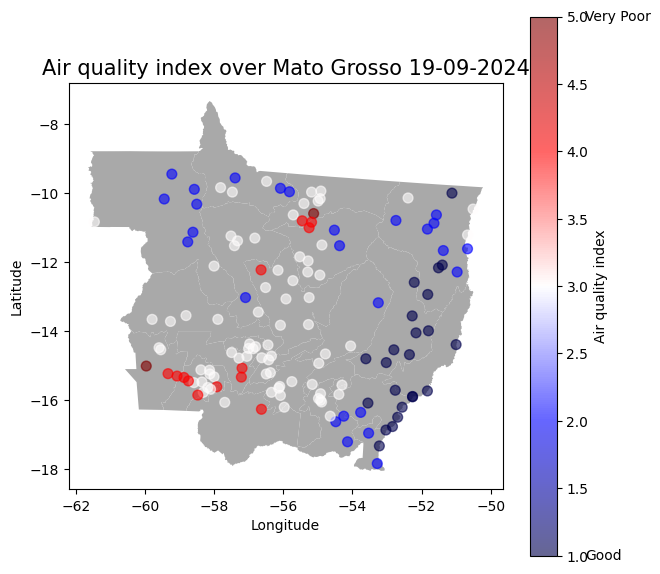

In [ ]:
plot_state_data(plot_mt_df, mt, "Mato Grosso 19-09-2024")

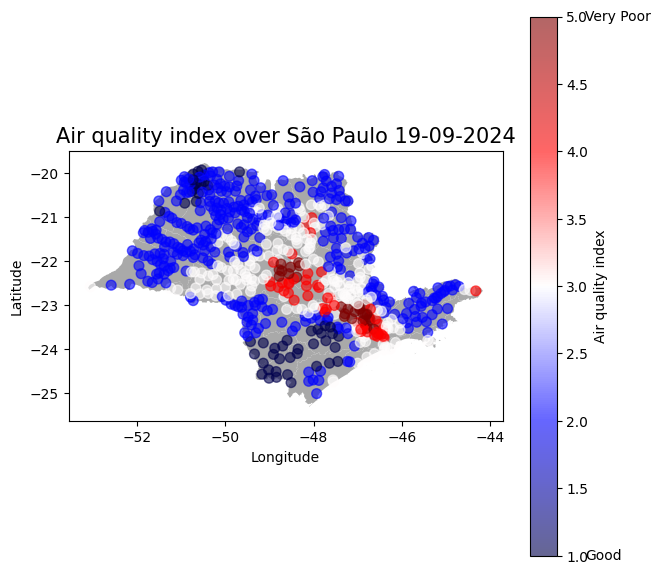

In [ ]:
plot_state_data(plot_sp_df, sp, "São Paulo 19-09-2024")

In [ ]:
def consult_air_quality_historical(consult_dict: dict, time_unix: str) -> list:
  air_quality = []

  for item in consult_dict:
      city_air = requests.get(f"http://api.openweathermap.org/data/2.5/air_pollution/history?lat={item['lat_rounded']}&lon={item['lon_rounded']}&start={time_unix}&end={time_unix}&appid={API_KEY}").json()
      air_quality.append({'name': item['name'], 'aqi': city_air['list'][0]['main']['aqi'], 'co': float(city_air['list'][0]['components']['co']), 'no': float(city_air['list'][0]['components']['no']), \
          'no2': float(city_air['list'][0]['components']['no2']), 'o3': float(city_air['list'][0]['components']['o3']), 'so2': float(city_air['list'][0]['components']['so2']), 'pm2_5': float(city_air['list'][0]['components']['pm2_5']), \
          'pm10': float(city_air['list'][0]['components']['pm10']), 'nh3': float(city_air['list'][0]['components']['nh3'])})
      time.sleep(0.5)

  return air_quality

In [ ]:
air_quality_sp_25_08 = consult_air_quality_historical(consult_dict_sp, "1724598000")

In [ ]:
air_quality_sp_18_09 = consult_air_quality_historical(consult_dict_sp, "1726056000")

In [ ]:
air_quality_sp_25_08_df = spark.createDataFrame(air_quality_sp_25_08
                                               , schema=df_schema)

In [ ]:
air_quality_sp_18_09_df = spark.createDataFrame(air_quality_sp_18_09
                                               , schema=df_schema)

In [ ]:
aqi_coords_sp_25_08 = prepare_dataframes(air_quality_sp_25_08_df, df_sp)
plot_sp_df_25_08 = aqi_coords_sp_25_08.toPandas()

In [ ]:
aqi_coords_sp_18_09 = prepare_dataframes(air_quality_sp_18_09_df, df_sp)
plot_sp_df_18_09 = aqi_coords_sp_18_09.toPandas()

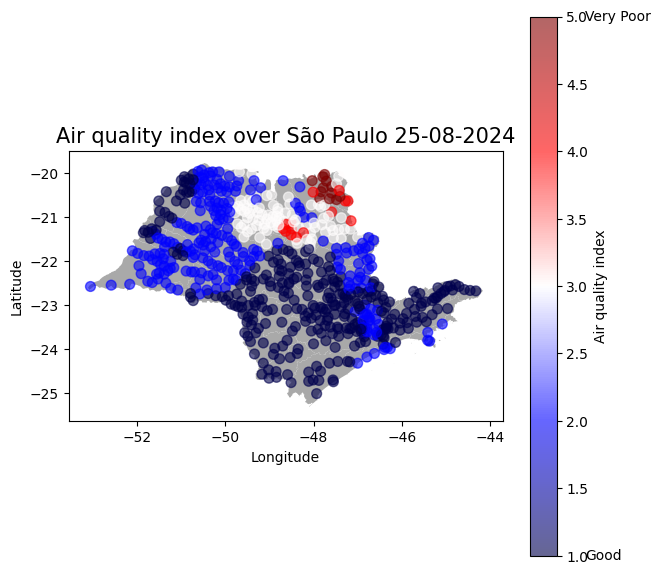

In [ ]:
plot_state_data(plot_sp_df_25_08, sp, "São Paulo 25-08-2024")

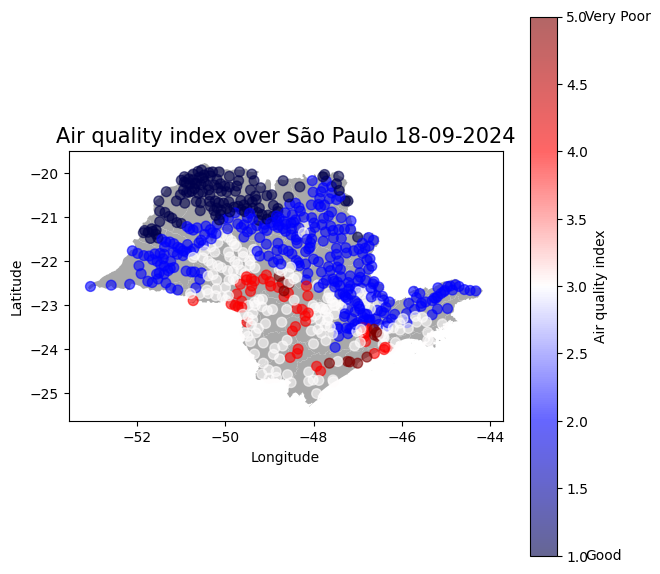

In [ ]:
plot_state_data(plot_sp_df_18_09, sp, "São Paulo 18-09-2024")